# CNN

Initially I started with a simple CNN in order to find out where the base performance of a CNN could be around.

In [1]:
%load_ext tensorboard

In [28]:
from pandas import read_parquet
from data import file
from reporting.evaluation import plot_confusion_matrix
import json

In [3]:
data_train = read_parquet(file.news_articles_cleaned_train)
data_test = read_parquet(file.news_articles_cleaned_test)
data_val = read_parquet(file.news_articles_cleaned_val)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, InputLayer
from tensorflow.keras import Sequential
import os
import datetime
from tensorflow import keras
from keras.callbacks import TensorBoard
from preprocessing.text import extract_vocabulary
from models.text.layers import create_text_vectorization, create_word_embedding
from sklearn.preprocessing import LabelBinarizer
    
    
def build_model(X_train, y_train, conv_num_filters=128, conv_kernel_size=7):

    vocabulary, embedding_length = extract_vocabulary(X_train, verbose=True)
    vectorize_layer = create_text_vectorization(vocabulary)
    embedding_layer = create_word_embedding(vocabulary, embedding_length)

    output_classes = len(label_binarizer.classes_)
    
    model = Sequential(name="cnn")
    model.add(InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    model.add(vectorize_layer)
    model.add(embedding_layer)
    model.add(Conv1D(conv_num_filters, conv_kernel_size, activation="relu", strides=1, padding="valid", name="conv_1"))
    model.add(GlobalMaxPooling1D(name="global_max_pool_1"))
    model.add(Dense(output_classes, activation=tf.nn.softmax, name="prediction"))

    return (model)

In [16]:
X_train = data_train.text_tokenized_stemmed
y_train = data_train.label

X_test = data_test.text_tokenized_stemmed
y_test = data_test.label

X_val = data_val.text_tokenized_stemmed
y_val = data_val.label

In [7]:
from preprocessing.categorical import binarizer
label_binarizer = binarizer(y_train)
model = build_model(X_train, y_train)
model.summary()

Median sequence length:       : 171
Percentil                     : 0.98)
Cutoff sequence length        : 588
Max sequence length           : 2590
Embedding length              : 588
Vocabulary length             : 139291


2021-11-23 05:30:05.918033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 05:30:06.022624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 05:30:06.023568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 05:30:06.026438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         41787300  
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 128)         268928    
_________________________________________________________________
global_max_pool_1 (GlobalMax (None, 128)               0         
_________________________________________________________________
prediction (Dense)           (None, 9)                 1161      
Total params: 42,057,389
Trainable params: 270,089
Non-trainable params: 41,787,300
_________________________________________________________________


In [8]:
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

learning_rate=0.01
model_metric = ["accuracy"]
loss_function = CategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss_function, optimizer=optimizer, metrics=model_metric)

In [9]:
data_train.label.unique()

array(['International', 'Inland', 'Kultur', 'Panorama', 'Web', 'Sport',
       'Wirtschaft', 'Wissenschaft', 'Etat'], dtype=object)

In [17]:

x_train = data_train['text_stem']
y_train_bin = label_binarizer.transform(y_train)

x_test = data_test['text_stem']
y_test_bin = label_binarizer.transform(y_test)

x_val = data_val['text_stem']
y_val_bin = label_binarizer.transform(y_val)

In [11]:
batch_size = 32
train_input = tf.data.Dataset.from_tensor_slices((x_train, y_train_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_input = tf.data.Dataset.from_tensor_slices((x_test, y_test_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_input


<PrefetchDataset shapes: ((None,), (None, 9)), types: (tf.string, tf.int64)>

In [12]:
#%tensorboard --logdir logs/fit

#callbacks = [TensorBoard("logs/fit", histogram_freq=1)]
callbacks = []
history = model.fit(train_input, validation_data=test_input, callbacks=callbacks, epochs=5)

Epoch 1/5


2021-11-23 05:31:13.220556: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-23 05:31:14.387161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


226/226 [==============================] - 65s 226ms/step - loss: 1.7248 - accuracy: 0.4056 - val_loss: 1.4763 - val_accuracy: 0.4903
Epoch 2/5
226/226 [==============================] - 34s 152ms/step - loss: 1.2039 - accuracy: 0.5945 - val_loss: 1.4238 - val_accuracy: 0.5291
Epoch 3/5
226/226 [==============================] - 35s 155ms/step - loss: 0.8033 - accuracy: 0.7345 - val_loss: 1.5678 - val_accuracy: 0.5388
Epoch 4/5
226/226 [==============================] - 38s 167ms/step - loss: 0.4985 - accuracy: 0.8358 - val_loss: 2.0620 - val_accuracy: 0.4981
Epoch 5/5
226/226 [==============================] - 35s 155ms/step - loss: 0.3332 - accuracy: 0.8880 - val_loss: 1.9736 - val_accuracy: 0.5369


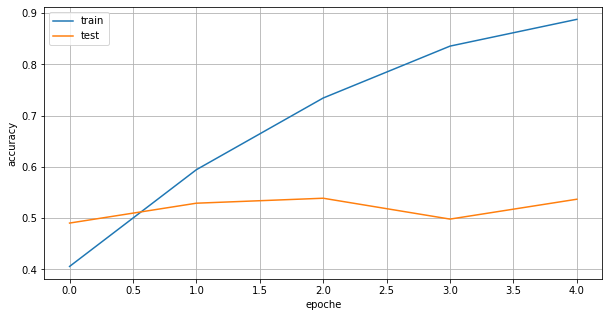

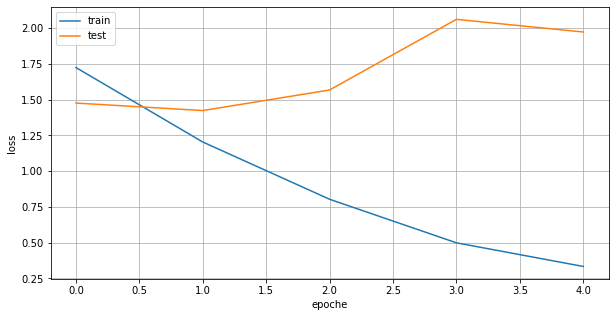

In [13]:
from reporting.training import plot_history
    
plot_history(history)

## Evaluation

pandas.core.series.Series

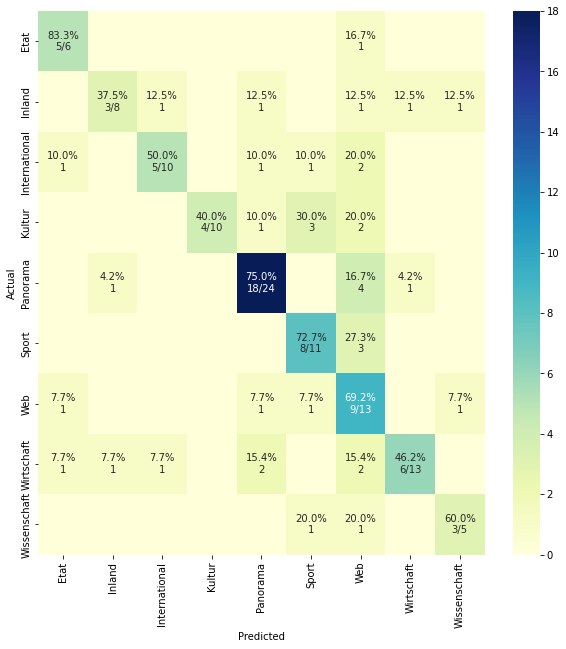

In [24]:
count = 100
expected = y_val[0:count]
predicted = label_binarizer.inverse_transform(model.predict(x_val[0:count]))
plot_confusion_matrix(expected, predicted)

## Write files for reporting

In [29]:
reporting_data = {
    "expected": expected.tolist(),
    "predicted": predicted.tolist(),
}
with open(file.reporting_data_report_cnn, 'w') as f:
    json.dump(reporting_data, f)